**DHS out-of-country cross-validated model results.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-Saved-Data" data-toc-modified-id="Load-Saved-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Saved Data</a></span><ul class="toc-item"><li><span><a href="#Load-labels,-locs,-and-years" data-toc-modified-id="Load-labels,-locs,-and-years-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load <code>labels</code>, <code>locs</code>, and <code>years</code></a></span></li><li><span><a href="#Load-loc_dict" data-toc-modified-id="Load-loc_dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load <code>loc_dict</code></a></span></li><li><span><a href="#Get-urban-v.-rural-indices" data-toc-modified-id="Get-urban-v.-rural-indices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get urban v. rural indices</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li></ul></li><li><span><a href="#Load-saved-preds" data-toc-modified-id="Load-saved-preds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load saved preds</a></span><ul class="toc-item"><li><span><a href="#Create-CSV-of-all-preds" data-toc-modified-id="Create-CSV-of-all-preds-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create CSV of all preds</a></span></li></ul></li><li><span><a href="#Overall-MSE,-$R^2$,-$r^2$,-rank-corr" data-toc-modified-id="Overall-MSE,-$R^2$,-$r^2$,-rank-corr-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overall MSE, $R^2$, $r^2$, rank-corr</a></span><ul class="toc-item"><li><span><a href="#Individual-model-results" data-toc-modified-id="Individual-model-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Individual model results</a></span></li><li><span><a href="#Model-Similarity-Heatmaps" data-toc-modified-id="Model-Similarity-Heatmaps-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model Similarity Heatmaps</a></span></li><li><span><a href="#Cumulative-analysis" data-toc-modified-id="Cumulative-analysis-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cumulative analysis</a></span></li></ul></li><li><span><a href="#Break-down-by-country,-urban/rural" data-toc-modified-id="Break-down-by-country,-urban/rural-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Break-down by country, urban/rural</a></span></li><li><span><a href="#$r^2$-over-all-countries" data-toc-modified-id="$r^2$-over-all-countries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>$r^2$ over all countries</a></span></li><li><span><a href="#Break-down-by-country-year,-urban/rural" data-toc-modified-id="Break-down-by-country-year,-urban/rural-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Break-down by country-year, urban/rural</a></span></li><li><span><a href="#Urban/rural" data-toc-modified-id="Urban/rural-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Urban/rural</a></span><ul class="toc-item"><li><span><a href="#By-Country" data-toc-modified-id="By-Country-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>By Country</a></span></li></ul></li><li><span><a href="#Model-performance-as-function-of-NL" data-toc-modified-id="Model-performance-as-function-of-NL-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model performance as function of NL</a></span><ul class="toc-item"><li><span><a href="#When-NL-=-0" data-toc-modified-id="When-NL-=-0-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>When NL = 0</a></span></li><li><span><a href="#Predictions-vs.-NL-mean" data-toc-modified-id="Predictions-vs.-NL-mean-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Predictions vs. NL mean</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import itertools
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
from batchers import dataset_constants
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds, symmetric_heatmap

In [3]:
LOGS_ROOT_DIR = '../logs/'
DATASET_NAME = '2009-17'

MODEL_NAME_TO_DIR = {
    # KNN
    'KNN NL mean scalar': 'dhs_knn/nlmean_scalar',
    # 'KNN NL center scalar': 'dhs_knn/nlcenter_scalar',
    # 'KNN NL hist': 'dhs_knn/nl_hist',

    # GBT
    # 'GBT NL mean scalar': 'dhs_gbt/nls_mean',

    # Ridge
    'Ridge NL mean scalar': 'dhs_ridge/nlmean_scalar',
    'Ridge NL center scalar': 'dhs_ridge/nlcenter_scalar',
    'Ridge RGB hist': 'dhs_ridge/rgb_hist',
    'Ridge MS hist': 'dhs_ridge/ms_hist',
    'Ridge NL hist': 'dhs_ridge/nl_hist',
    'Ridge RGB+NL hist': 'dhs_ridge/rgbnl_hist',
    'Ridge MS+NL hist': 'dhs_ridge/msnl_hist',

    # Resnet
    'Resnet-18 MS': 'dhs_resnet/ms',
    'Resnet-18 MS+NL concat': 'dhs_resnet/msnl_concat',
    'Resnet-18 NL': 'dhs_resnet/nl',

    # Transfer
    'Resnet-18 RGB Transfer': 'transfer_2009-17nl_nlcenter_18preact_ms_b64_fc001_conv001_lr0001',
    'Resnet-18 MS Transfer': 'transfer_2009-17nl_nlcenter_18preact_ms_b64_fc001_conv001_lr0001',
}

MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())

# Load Saved Data

## Load `labels`, `locs`, and `years`

In [4]:
npz = load_npz('../data/dhs_image_hists.npz')

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years), len(nls_center), len(nls_mean)]) == num_examples)

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': 0,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    },
    ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [5]:
loc_dict_path = '../data/dhs_loc_dict.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Get urban v. rural indices

In [6]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 6801	 num rural: 12868


## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [7]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(num_examples, dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

country_indices['overall'] = np.arange(num_examples)

In [8]:
country_year_indices = defaultdict(list)

for i, (lat, lon) in enumerate(locs):
    cy = loc_dict[(lat, lon)]['country_year']
    country_year_indices[cy].append(i)

for cy in country_year_indices:
    country_year_indices[cy] = np.asarray(country_year_indices[cy])

# Load saved preds

In [9]:
preds = {}

for model_name, model_dir in MODEL_NAME_TO_DIR.items():
    print(model_name)
    npz_path = os.path.join(LOGS_ROOT_DIR, model_dir, 'test_preds.npz')
    preds[model_name] = load_npz(npz_path)['test_preds']

KNN NL mean scalar
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge NL mean scalar
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge NL center scalar
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge RGB hist
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge MS hist
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge NL hist
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge RGB+NL hist
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge MS+NL hist
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Resnet-18 MS
locs: dtype=float32, shape=(19669, 2)
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Resnet-18 MS+NL concat
locs: dtype=float32, shape=(19669, 2)
labels: dtype=float32, shap

## Create CSV of all preds

In [10]:
preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'year', 'urban', 'label'] + MODEL_NAMES)
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]
preds_df['label'] = labels
preds_df['year'] = years
preds_df['country'] = np.asarray(dataset_constants.DHS_COUNTRIES)[country_labels]
preds_df.loc[:, 'urban'] = False
preds_df.loc[urban_indices, 'urban'] = True

for model_name in MODEL_NAMES:
    preds_df[model_name] = preds[model_name]

# preds_df.to_csv('dhs_ooc_preds_ooc.csv', index=False)

In [11]:
with pd.option_context('display.max_rows', 8):
    display(preds_df)

,lat,lon,country,year,urban,label,KNN NL mean scalar,Resnet-18 MS,Resnet-18 MS Transfer,Resnet-18 MS+NL concat,Resnet-18 NL,Resnet-18 RGB Transfer,Ridge MS hist,Ridge MS+NL hist,Ridge NL center scalar,Ridge NL hist,Ridge NL mean scalar,Ridge RGB hist,Ridge RGB+NL hist
0,-11.915085,22.876839,angola,2011,False,-1.019361,0.009687,-0.368321,-0.235497,-0.111741,0.198592,-0.235497,-0.211548,-0.136666,-0.228462,-0.055156,-0.263023,-0.251392,-0.186917
1,-11.886975,22.924997,angola,2011,False,-1.090052,-0.133958,-0.038393,0.362298,0.040727,0.038825,0.362298,-0.331312,-0.216101,-0.308140,-0.125419,-0.268219,-0.218040,-0.272411
2,-9.498591,17.830034,angola,2011,False,-1.143002,-0.203931,-0.725823,-0.363455,-0.599429,-0.268183,-0.363455,-0.165150,-0.477106,-0.308140,-0.359495,-0.288864,-0.152893,-0.314883
3,-8.864000,13.240764,angola,2011,True,1.056769,1.476273,1.060447,2.171072,1.561765,2.367558,2.171072,1.670230,1.087703,5.994560,1.583656,6.938428,0.773036,1.159504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19665,-18.031948,31.095280,zimbabwe,2015,True,1.268232,1.133497,1.033012,0.788579,1.105951,1.153041,0.788579,0.674059,1.049920,0.197972,1.138939,0.250696,0.273901,1.130512
19666,-18.021593,31.084930,zimbabwe,2015,True,1.506693,1.195909,1.116351,1.184118,1.201929,1.252914,1.184118,0.843300,1.145234,0.475417,1.225315,0.315317,0.306029,1.200058
19667,-17.989489,31.033354,zimbabwe,2015,True,1.882921,1.117101,0.993798,0.942547,1.077916,1.062907,0.942547,0.847852,1.154399,0.413100,1.171655,0.165820,0.343904,1.216366
19668,-17.998350,31.042618,zimbabwe,2015,True,1.880099,1.127561,1.006318,0.815983,1.151231,1.188458,0.815983,0.856749,1.166607,0.324281,1.188742,0.239270,0.333028,1.223257


# Overall MSE, $R^2$, $r^2$, rank-corr

## Individual model results

In [12]:
overall_df = evaluate_df(preds_df, cols=MODEL_NAMES)
overall_df.sort_values(by='r2', ascending=False, inplace=True)
colordisplay(overall_df)

,r2,R2,mse,rank
Resnet-18 MS+NL concat,0.66804,0.667578,0.217079,0.764305
Resnet-18 NL,0.661049,0.66097,0.221395,0.739858
KNN NL mean scalar,0.656155,0.655995,0.224643,0.747841
Ridge NL hist,0.649837,0.649817,0.228678,0.721912
Ridge RGB+NL hist,0.64525,0.645235,0.23167,0.743104
Ridge MS+NL hist,0.624247,0.623979,0.245551,0.723235
Resnet-18 MS,0.615363,0.614314,0.251862,0.728049
Resnet-18 MS Transfer,0.556384,0.555467,0.290291,0.668024
Resnet-18 RGB Transfer,0.556384,0.555467,0.290291,0.668024
Ridge MS hist,0.277112,0.26637,0.479078,0.441796


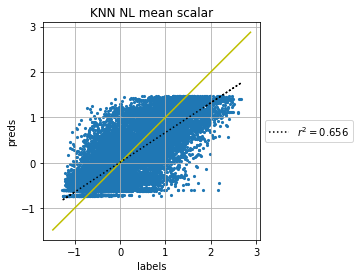

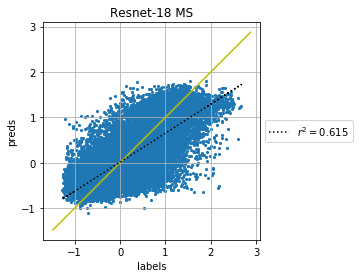

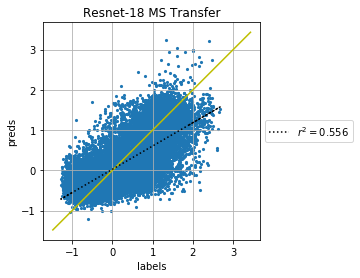

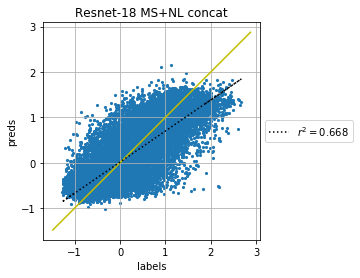

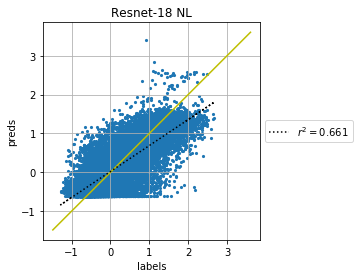

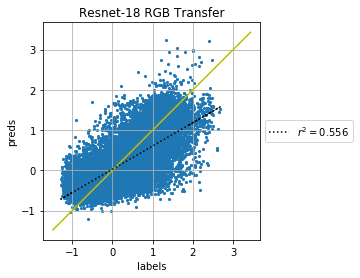

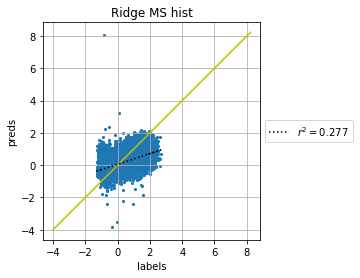

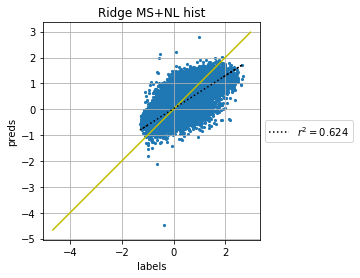

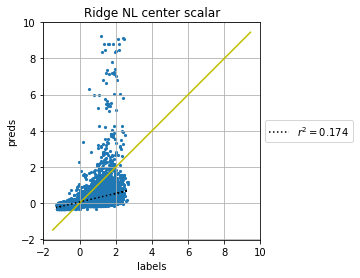

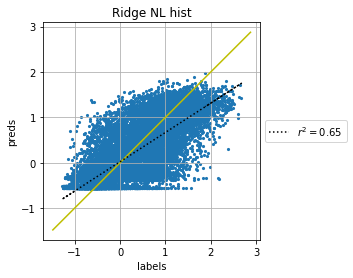

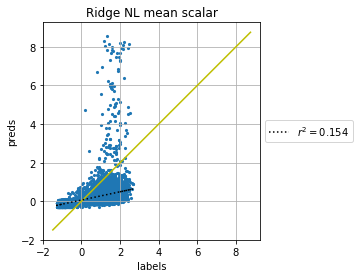

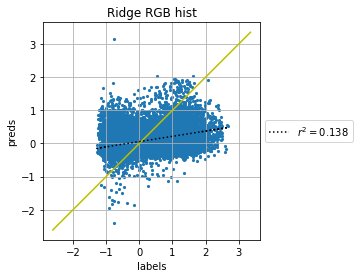

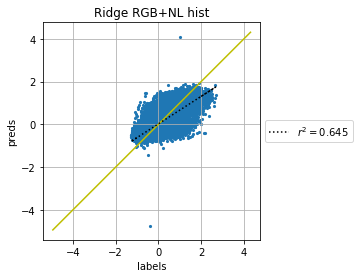

In [13]:
for model_name in MODEL_NAMES:
    model_preds = preds[model_name]
    scatter_preds(
        labels=labels,
        preds=model_preds,
        title=model_name,
        figsize=(4, 4))

## Model Similarity Heatmaps

In [14]:
model_names_by_mse = overall_df.sort_values(by='mse').index
num_models = len(preds)

r2_mat = np.eye(num_models, dtype=np.float64)
rank_mat = np.eye(num_models, dtype=np.float64)

for i, j in itertools.combinations(range(num_models), r=2):
    model_name1 = model_names_by_mse[i]
    model_name2 = model_names_by_mse[j]

    m1_preds = preds[model_name1]
    m2_preds = preds[model_name2]

    r2_mat[i, j] = calc_score(m1_preds, m2_preds, metric='r2')
    rank_mat[i, j] = calc_score(m1_preds, m2_preds, metric='rank')
    r2_mat[j, i] = r2_mat[i, j]
    rank_mat[j, i] = rank_mat[i, j]

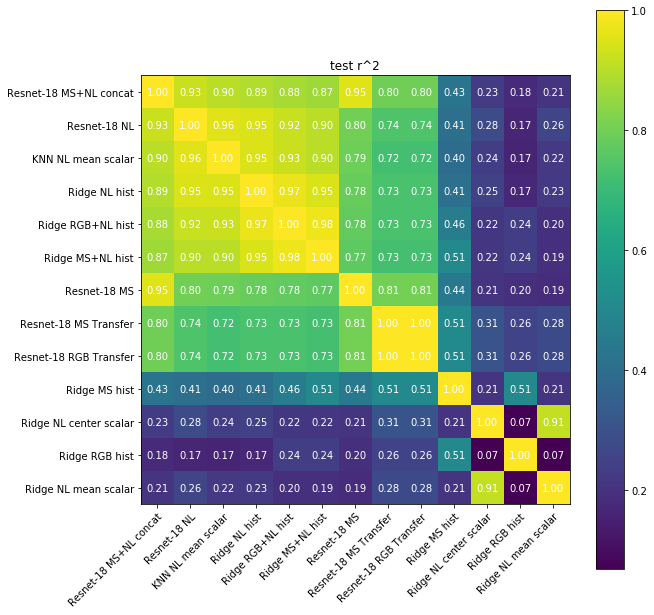

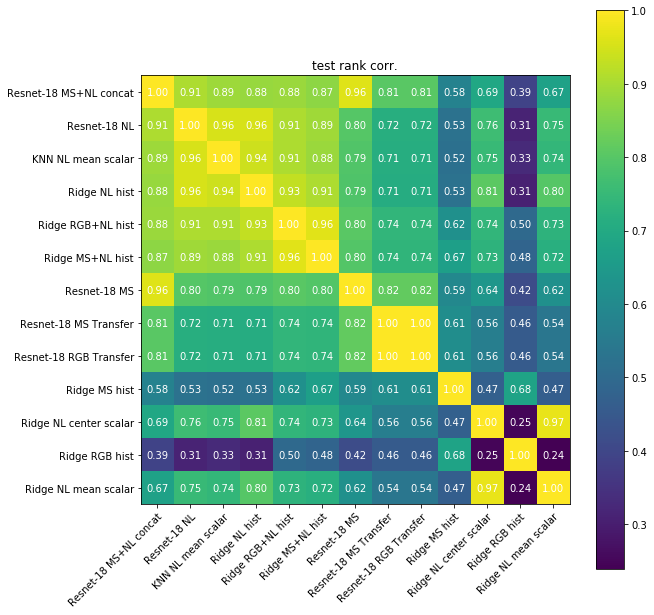

In [15]:
symmetric_heatmap(r2_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test r^2')
symmetric_heatmap(rank_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test rank corr.')

## Cumulative analysis

In [16]:
ridge_model_indices, ridge_model_names = [], []
resnet_model_indices, resnet_model_names = [], []

for i, model_name in enumerate(model_names_by_mse):
    if 'Resnet' not in model_name:
        ridge_model_indices.append(i)
        ridge_model_names.append(model_name)
    elif 'Resnet' in model_name:
        resnet_model_indices.append(i)
        resnet_model_names.append(model_name)

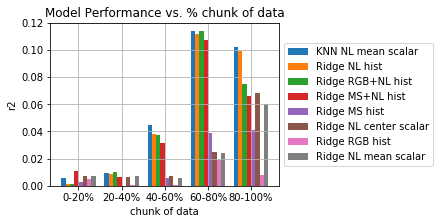

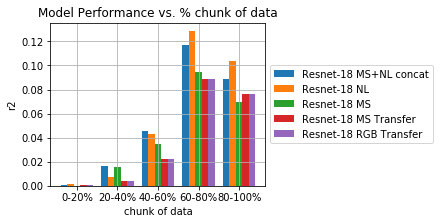

In [17]:
chunk_r2s = np.zeros([len(model_names_by_mse), 5])
for i, model_name in enumerate(model_names_by_mse):
    chunk_r2s[i, :] = chunk_vs_score(preds=preds[model_name], labels=labels, nchunks=5, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[ridge_model_indices], figsize=(6, 3),
                    legends=ridge_model_names, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[resnet_model_indices], figsize=(6, 3),
                    legends=resnet_model_names, metric='r2')

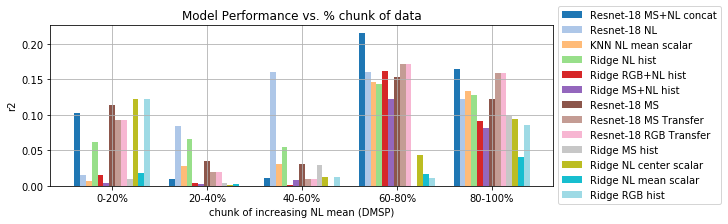

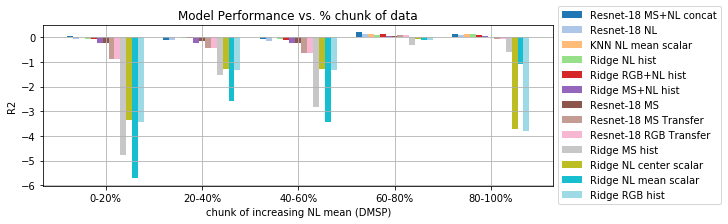

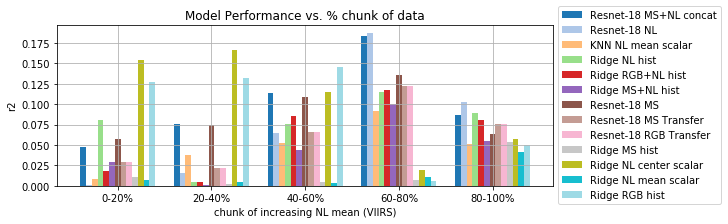

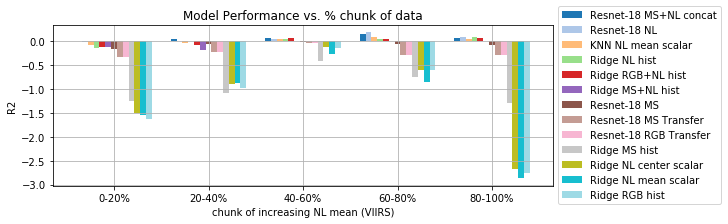

In [18]:
dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

for name, mask in [('DMSP', dmsp_mask), ('VIIRS', viirs_mask)]:
    chunk_r2s = np.zeros([len(model_names_by_mse), 5])
    chunk_R2s = np.zeros([len(model_names_by_mse), 5])
    for i, model_name in enumerate(model_names_by_mse):
        chunk_r2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='r2', chunk_value=nls_mean[mask])
        chunk_R2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='R2', chunk_value=nls_mean[mask])

    plot_chunk_vs_score(scores=chunk_r2s, legends=overall_df.index, metric='r2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')
    plot_chunk_vs_score(scores=chunk_R2s, legends=overall_df.index, metric='R2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')

In [19]:
cumulative_r2s = np.zeros([len(model_names_by_mse), num_examples])

for i, model_name in enumerate(model_names_by_mse):
    r2s, labels_sorted = sorted_scores(
        preds=preds[model_name], labels=labels, metric='r2', sort='increasing')
    cumulative_r2s[i, :] = r2s

/atlas/u/chrisyeh/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
/atlas/u/chrisyeh/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)


In [20]:
cumulative_r2_df = pd.DataFrame(
    data=cumulative_r2s.T,
    index=pd.Index(np.sort(labels), name='wealthpooled'),
    columns=model_names_by_mse)
with pd.option_context('display.max_rows', 4):
    display(cumulative_r2_df)

cumulative_r2_df.to_csv('dhs_ooc_cumulative_r2.csv', index=True)

,Resnet-18 MS+NL concat,Resnet-18 NL,KNN NL mean scalar,Ridge NL hist,Ridge RGB+NL hist,Ridge MS+NL hist,Resnet-18 MS,Resnet-18 MS Transfer,Resnet-18 RGB Transfer,Ridge MS hist,Ridge NL center scalar,Ridge RGB hist,Ridge NL mean scalar
wealthpooled,,,,,,,,,,,,,
-1.282605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1.269092,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.651037,0.668008,0.660998,0.656096,0.649772,0.645195,0.624198,0.615323,0.556260,0.556260,0.277074,0.174163,0.137538,0.154366
2.675832,0.668040,0.661050,0.656155,0.649837,0.645250,0.624247,0.615363,0.556384,0.556384,0.277112,0.174327,0.137615,0.154494


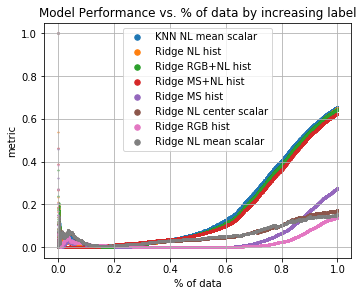

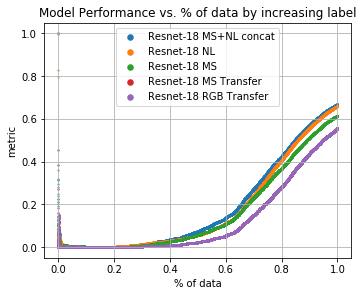

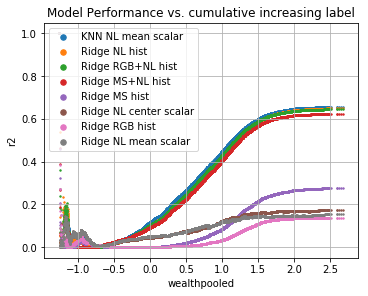

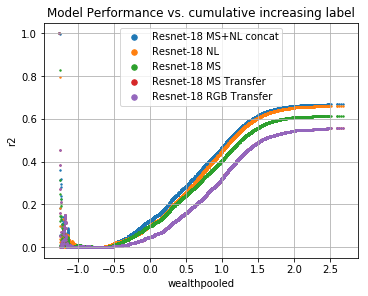

In [21]:
plot_percdata_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_percdata_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    labels_list=[np.sort(labels)] * len(ridge_model_indices),
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    labels_list=[np.sort(labels)] * len(resnet_model_indices),
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

# Break-down by country, urban/rural

In [22]:
country_df = (
    preds_df
    .groupby('country')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
country_urban_df = (
    preds_df
    .groupby(['country', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(country_df)
    display(country_urban_df)

r2     R2    mse   rank
country  model                                         
angola   KNN NL mean scalar  0.744  0.694  0.365  0.845
         Resnet-18 MS        0.731  0.704  0.353  0.824
...                            ...    ...    ...    ...
zimbabwe Ridge RGB hist      0.022 -0.302  1.105  0.137
         Ridge RGB+NL hist   0.723  0.475  0.445  0.818

[299 rows x 4 columns]

r2     R2    mse   rank
country  urban model                                             
angola   False KNN NL mean scalar  3.306e-01 -0.460  0.348  0.424
               Resnet-18 MS        2.641e-01 -0.174  0.280  0.335
...                                      ...    ...    ...    ...
zimbabwe True  Ridge RGB hist      3.009e-05 -9.660  2.262 -0.007
               Ridge RGB+NL hist   1.807e-01 -2.620  0.768  0.442

[598 rows x 4 columns]

# $r^2$ over all countries

In [23]:
# get mean and median r^2 across countries
country_r2_df = country_df['r2'].unstack('model')
colordisplay(country_r2_df.describe().T)

print('urban:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), True), :].describe().T)

print('rural:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), False), :].describe().T)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,23,0.698513,0.074681,0.544468,0.654081,0.690323,0.756941,0.821689
Resnet-18 MS,23,0.657869,0.0853719,0.469802,0.617894,0.647461,0.726222,0.797395
Resnet-18 MS Transfer,23,0.600274,0.0924627,0.409516,0.54336,0.596152,0.663851,0.766277
Resnet-18 MS+NL concat,23,0.708929,0.0748315,0.577465,0.660315,0.6964,0.764424,0.833612
Resnet-18 NL,23,0.70734,0.0760763,0.553303,0.662089,0.713811,0.754456,0.834635
Resnet-18 RGB Transfer,23,0.600274,0.0924627,0.409516,0.54336,0.596152,0.663851,0.766277
Ridge MS hist,23,0.360381,0.173164,0.0674752,0.223194,0.357998,0.50661,0.610102
Ridge MS+NL hist,23,0.659927,0.0831724,0.493399,0.61472,0.662107,0.727172,0.780741
Ridge NL center scalar,23,0.410458,0.106555,0.210347,0.338903,0.395425,0.480234,0.658314


urban:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,23,0.440042,0.173438,0.0754702,0.346028,0.473277,0.554944,0.736667
Resnet-18 MS,23,0.371394,0.170471,0.0777625,0.241798,0.382102,0.469349,0.72448
Resnet-18 MS Transfer,23,0.356079,0.158407,0.0838018,0.270437,0.335006,0.454209,0.660456
Resnet-18 MS+NL concat,23,0.426541,0.176235,0.103456,0.31855,0.458982,0.520264,0.755643
Resnet-18 NL,23,0.448339,0.177712,0.0972218,0.343432,0.473523,0.568646,0.770807
Resnet-18 RGB Transfer,23,0.356079,0.158407,0.0838018,0.270437,0.335006,0.454209,0.660456
Ridge MS hist,23,0.251375,0.160904,0.0153936,0.127115,0.187064,0.363076,0.560891
Ridge MS+NL hist,23,0.415915,0.16857,0.0635822,0.315484,0.426349,0.539564,0.742107
Ridge NL center scalar,23,0.267058,0.125528,0.100015,0.185785,0.252911,0.302187,0.668626


rural:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,23,0.279795,0.122975,0.00656762,0.192563,0.285048,0.396437,0.446715
Resnet-18 MS,23,0.213269,0.098597,0.0639824,0.138573,0.209696,0.283155,0.388316
Resnet-18 MS Transfer,23,0.142974,0.0891028,0.0102051,0.0699499,0.152068,0.204965,0.314882
Resnet-18 MS+NL concat,23,0.286523,0.114818,0.0692981,0.184076,0.294571,0.384678,0.46273
Resnet-18 NL,23,0.279941,0.123299,0.0229559,0.19453,0.28978,0.368905,0.464436
Resnet-18 RGB Transfer,23,0.142974,0.0891028,0.0102051,0.0699499,0.152068,0.204965,0.314882
Ridge MS hist,23,0.0489672,0.0516805,1.87109e-06,0.00867333,0.0287693,0.0731838,0.1516
Ridge MS+NL hist,23,0.23628,0.106948,0.0401146,0.157776,0.199307,0.338987,0.410408
Ridge NL center scalar,23,0.141686,0.0725307,0.0143225,0.0940544,0.150672,0.199992,0.258175


,weighted r2,median r2,mean r2,overall r2
model,,,,
Resnet-18 MS+NL concat,0.689405,0.6964,0.708929,0.66804
Resnet-18 NL,0.684241,0.713811,0.70734,0.661049
KNN NL mean scalar,0.676488,0.690323,0.698513,0.656155
Ridge NL hist,0.661163,0.679567,0.684136,0.649837
Ridge RGB+NL hist,0.646202,0.673057,0.672412,0.64525
Resnet-18 MS,0.639297,0.647461,0.657869,0.615363
Ridge MS+NL hist,0.633454,0.662107,0.659927,0.624247
Resnet-18 MS Transfer,0.575132,0.596152,0.600274,0.556384
Resnet-18 RGB Transfer,0.575132,0.596152,0.600274,0.556384


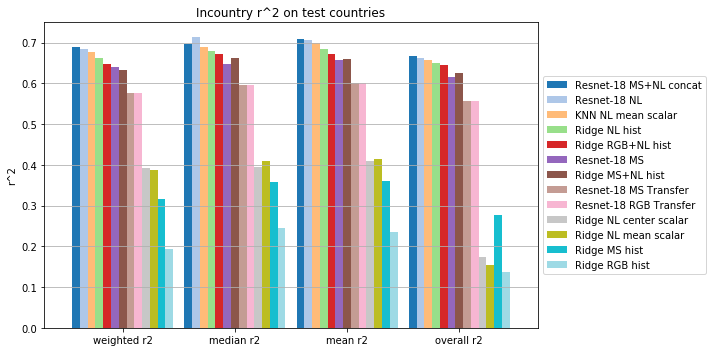

In [24]:
def weighted_r2(x):
    '''
    Args
    - x: pd.Series, index is (country, metric), value is score

    Returns:
    - y: float
    '''
    y = np.sum([
        x[country] * len(country_indices[country]) / len(labels)
        for country in x.index.get_level_values(0)
    ])
    return y

median_r2s = country_r2_df.median(axis=0).rename('median r2')
mean_r2s = country_r2_df.mean(axis=0).rename('mean r2')
weighted_r2s = country_r2_df.apply(weighted_r2, axis=0).rename('weighted r2')
overall_r2s = overall_df.loc[MODEL_NAMES, 'r2'].rename('overall r2')

agg_r2s = pd.concat([weighted_r2s, median_r2s, mean_r2s, overall_r2s], axis=1)
agg_r2s.sort_values(by='weighted r2', ascending=False, inplace=True)
colordisplay(agg_r2s)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
agg_r2s.T.plot(kind='bar', ax=ax, width=0.9, colormap='tab20')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center',
         rotation_mode='anchor')
ax.set_ylabel('r^2')
ax.set_title('Incountry r^2 on test countries')
ax.grid(True, axis='y')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

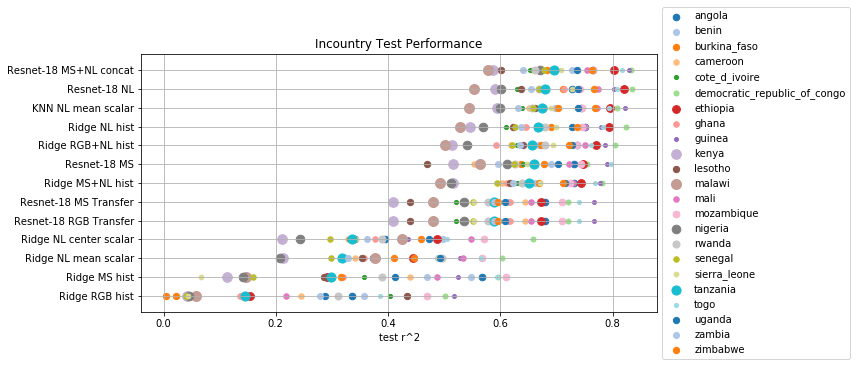

In [25]:
def plot_country_performance(df, model_names, title, xlabel):
    '''
    Args
    - df: pd.DataFrame, df.loc[country, model_name] gives model performance on a particular country
    - model_names: list of str
    - title: str
    - xlabel: str
    '''
    CMAP_FN = plt.cm.get_cmap('tab20')
    COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 20] for i in range(len(dataset_constants.DHS_COUNTRIES))]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
        r2s = df.loc[country, model_names]
        size = len(country_indices[country]) / len(labels) * 1000
        ax.scatter(x=r2s, y=model_names, s=size, c=[COUNTRY_YEAR_COLORS[i]], label=country)

    ax.invert_yaxis()  # invert direction to put best-performing models at the top
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

plot_country_performance(
    df=country_r2_df,
    model_names=list(agg_r2s.index),
    title='Incountry Test Performance',
    xlabel='test r^2')

# Break-down by country-year, urban/rural

In [26]:
countryyear_df = (
    preds_df
    .groupby(['country', 'year'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
countryyear_urban_df = (
    preds_df
    .groupby(['country', 'year', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(countryyear_df)
    display(countryyear_urban_df)

r2     R2    mse   rank
country  year model                                         
angola   2011 KNN NL mean scalar  0.774  0.745  0.354  0.836
              Resnet-18 MS        0.812  0.730  0.373  0.834
...                                 ...    ...    ...    ...
zimbabwe 2015 Ridge RGB hist      0.013 -0.598  1.255  0.119
              Ridge RGB+NL hist   0.677  0.417  0.458  0.762

[559 rows x 4 columns]

r2      R2    mse   rank
country  year urban model                                          
angola   2011 False KNN NL mean scalar  0.258  -1.012  0.415  0.395
                    Resnet-18 MS        0.286  -0.864  0.385  0.425
...                                       ...     ...    ...    ...
zimbabwe 2015 True  Ridge RGB hist      0.001 -13.311  2.762  0.074
                    Ridge RGB+NL hist   0.109  -3.124  0.796  0.317

[1118 rows x 4 columns]

In [27]:
# get mean and median r^2 across country_years
countryyear_r2_df = countryyear_df['r2'].unstack('model')
colordisplay(countryyear_r2_df.describe().T)

print('urban:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), True), :].describe().T)

print('rural:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), False), :].describe().T)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,43,0.690133,0.0813801,0.479544,0.637848,0.694632,0.75076,0.821689
Resnet-18 MS,43,0.653697,0.0868366,0.453303,0.607247,0.647461,0.7045,0.811791
Resnet-18 MS Transfer,43,0.595983,0.0926665,0.396446,0.531984,0.611089,0.65433,0.766277
Resnet-18 MS+NL concat,43,0.701049,0.0774413,0.516029,0.659455,0.704454,0.745232,0.833612
Resnet-18 NL,43,0.697347,0.0825524,0.480912,0.638868,0.700063,0.758139,0.834635
Resnet-18 RGB Transfer,43,0.595983,0.0926665,0.396446,0.531984,0.611089,0.65433,0.766277
Ridge MS hist,43,0.340865,0.170182,0.0432123,0.212588,0.325495,0.474548,0.689425
Ridge MS+NL hist,43,0.649208,0.0921762,0.385352,0.600532,0.662107,0.72691,0.780741
Ridge NL center scalar,43,0.413094,0.124035,0.199117,0.31598,0.390848,0.513635,0.658314


urban:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,43,0.414497,0.180363,0.0231789,0.319219,0.419831,0.556624,0.736667
Resnet-18 MS,43,0.374231,0.176675,0.0278564,0.263351,0.385168,0.493145,0.72448
Resnet-18 MS Transfer,43,0.35381,0.159667,0.0674222,0.254023,0.32674,0.451274,0.660456
Resnet-18 MS+NL concat,43,0.414315,0.185238,0.0395636,0.301954,0.427304,0.539909,0.755643
Resnet-18 NL,43,0.424737,0.184729,0.0398939,0.300315,0.446327,0.555023,0.770807
Resnet-18 RGB Transfer,43,0.35381,0.159667,0.0674222,0.254023,0.32674,0.451274,0.660456
Ridge MS hist,43,0.243247,0.162448,0.00677689,0.138021,0.204967,0.351081,0.562681
Ridge MS+NL hist,43,0.389027,0.177337,0.032433,0.287671,0.388521,0.515789,0.742107
Ridge NL center scalar,43,0.257731,0.125478,0.0138062,0.186522,0.244141,0.318554,0.668626


rural:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
KNN NL mean scalar,43,0.287807,0.133753,0.00656762,0.186604,0.292291,0.377656,0.526859
Resnet-18 MS,43,0.214268,0.112885,0.035268,0.123739,0.228998,0.303938,0.464408
Resnet-18 MS Transfer,43,0.148793,0.0996819,0.00120103,0.0603934,0.142845,0.226893,0.405251
Resnet-18 MS+NL concat,43,0.290619,0.125572,0.0317853,0.178181,0.312952,0.383567,0.498995
Resnet-18 NL,43,0.289086,0.129946,0.0229559,0.204112,0.28978,0.368781,0.546173
Resnet-18 RGB Transfer,43,0.148793,0.0996819,0.00120103,0.0603934,0.142845,0.226893,0.405251
Ridge MS hist,43,0.0435704,0.0518743,1.40979e-05,0.00286996,0.0164825,0.0793013,0.159158
Ridge MS+NL hist,43,0.238277,0.120817,0.0382979,0.140674,0.237255,0.321891,0.480575
Ridge NL center scalar,43,0.161191,0.0978059,0.000700371,0.095464,0.170446,0.218142,0.41783


# Urban/rural

In [28]:
urban_rural_df = (
    preds_df
    .groupby('urban')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model')
    .unstack('urban'))

with pd.option_context('display.max_rows', 20, 'display.precision', 3):
    display(urban_rural_df)

r2            R2           mse          rank       
urban                   False  True   False  True   False  True   False  True 
model                                                                         
KNN NL mean scalar      0.315  0.385  0.277  0.312  0.173  0.322  0.456  0.600
Resnet-18 MS            0.225  0.340  0.168  0.249  0.199  0.352  0.414  0.564
Resnet-18 MS Transfer   0.147  0.331  0.057  0.120  0.226  0.412  0.284  0.574
Resnet-18 MS+NL concat  0.315  0.395  0.288  0.348  0.170  0.305  0.478  0.608
Resnet-18 NL            0.308  0.407  0.268  0.341  0.175  0.308  0.421  0.627
Resnet-18 RGB Transfer  0.147  0.331  0.057  0.120  0.226  0.412  0.284  0.574
Ridge MS hist           0.016  0.202 -0.633 -0.379  0.391  0.646  0.109  0.458
Ridge MS+NL hist        0.283  0.378  0.205  0.253  0.190  0.350  0.410  0.601
Ridge NL center scalar  0.066  0.111 -0.383 -1.089  0.331  0.978  0.124  0.531
Ridge NL hist           0.313  0.401  0.270  0.294  0.175  0.331  0.378  0.620
Ridge NL mean scalar    0.069  0.098 -0.421 -1.132  0.340  0.998  0.138  0.512
Ridge RGB hist          0.005  0.114 -0.752 -0.797  0.420  0.841  0.103  0.377
Ridge RGB+NL hist       0.315  0.397  0.259  0.286  0.177  0.334  0.451  0.615

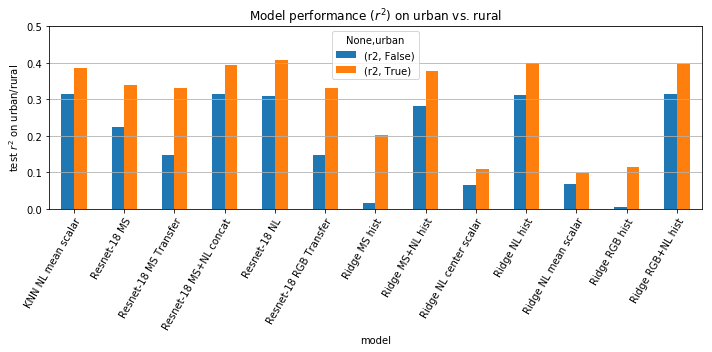

In [29]:
ax = urban_rural_df.loc[:, ('r2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $r^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.5)
ax.set_title('Model performance ($r^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

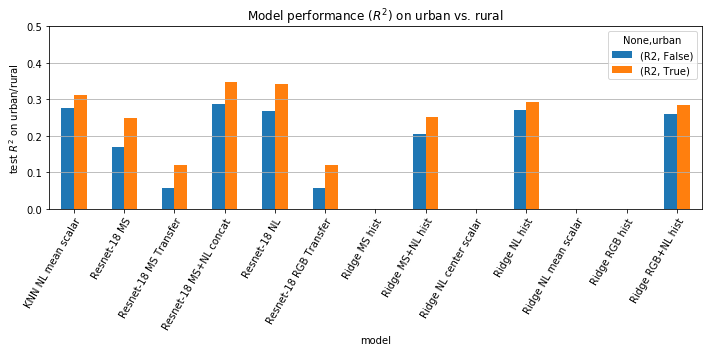

In [30]:
ax = urban_rural_df.loc[:, ('R2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $R^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.5)
ax.set_title('Model performance ($R^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

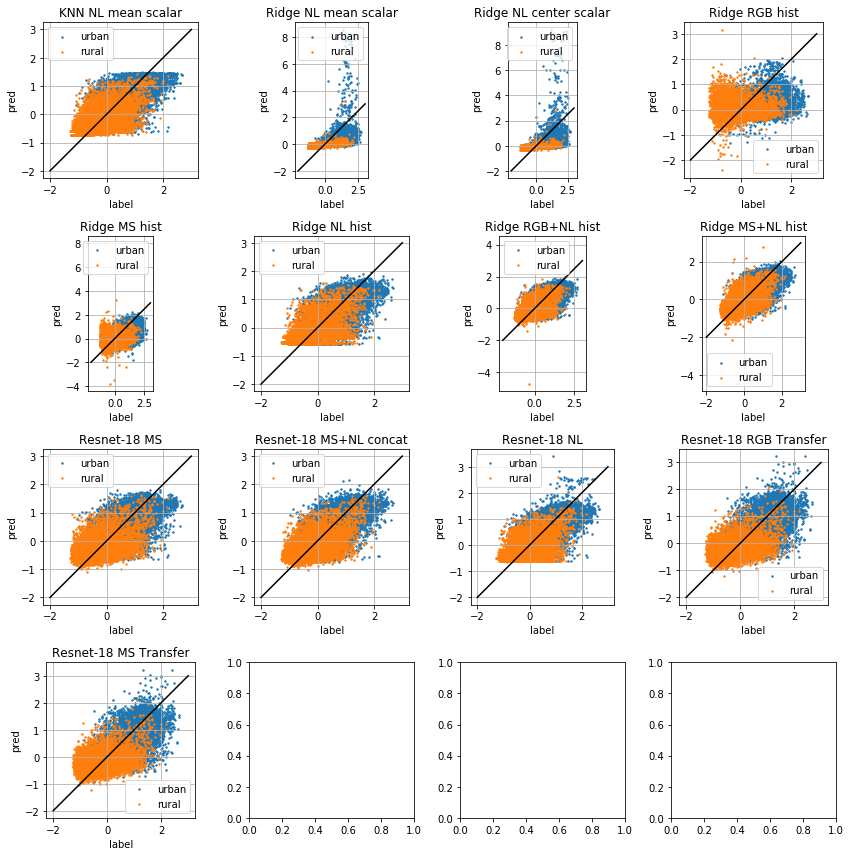

In [31]:
def plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices):
    '''
    Args
    - labels: np.array, shape [N]
    - preds: dict, model_name => np.array, shape [N]
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    nrows = int(np.ceil(np.sqrt(len(preds))))
    ncols = int(np.ceil(len(preds) / nrows))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=False, sharex=False, figsize=[ncols*3, nrows*3])
    for model_name, ax in zip(preds, axs.flat):
        ax.scatter(
            x=labels[urban_indices],
            y=preds[model_name][urban_indices],
            s=2, label='urban')
        ax.scatter(
            x=labels[rural_indices],
            y=preds[model_name][rural_indices],
            s=2, label='rural')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set(xlabel='label', ylabel='pred', title=model_name)
        xy_line = np.array([-2, 3])
        ax.plot(xy_line, xy_line, color='black')
        ax.legend()
    fig.tight_layout()
    plt.show()

plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices)

## By Country

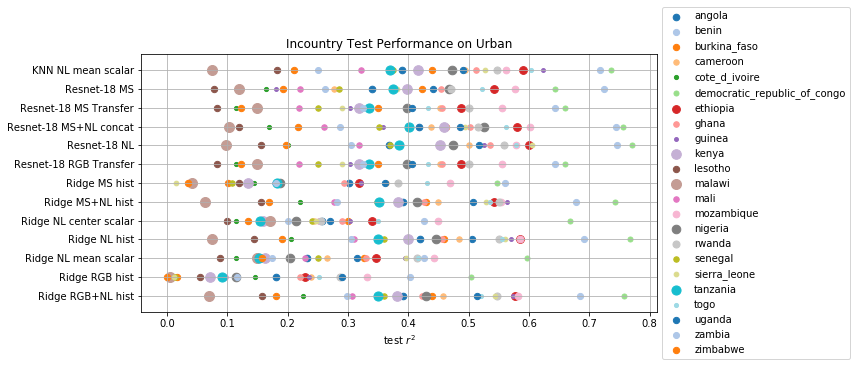

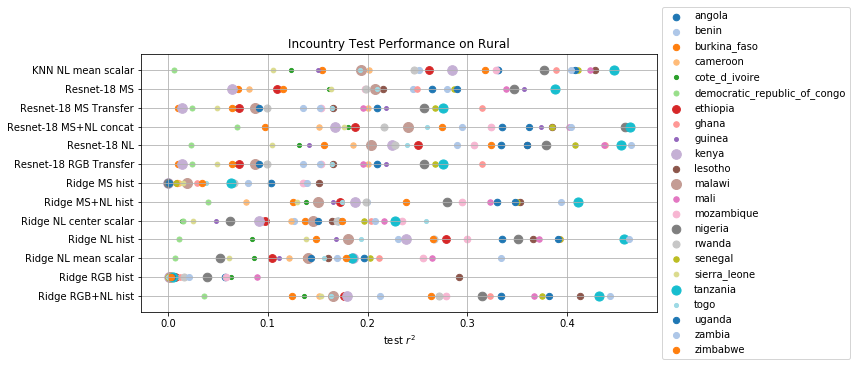

In [32]:
plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), True), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Urban',
    xlabel='test $r^2$')

plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), False), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Rural',
    xlabel='test $r^2$')

# Model performance as function of NL

## When NL = 0

In [33]:
from batchers.batcher import MEANS_DICT, STD_DEVS_DICT

dmsp0 = (0.0 - MEANS_DICT[DATASET_NAME]['DMSP']) / STD_DEVS_DICT[DATASET_NAME]['DMSP']
viirs0 = (0.0 - MEANS_DICT[DATASET_NAME]['VIIRS']) / STD_DEVS_DICT[DATASET_NAME]['VIIRS']

print('DMSP 0-value (after normalization):', dmsp0)
print('VIIRS 0-value (after normalization):', viirs0)

dmsp0_indices = (years < 2012) & (nls_mean == dmsp0)
viirs0_indices = (years >= 2012) & (nls_mean == viirs0)
nl0_indices = dmsp0_indices | viirs0_indices

assert np.all(nls_mean[nl0_indices] == dmsp0)
assert np.all(nls_center[nl0_indices] == dmsp0)

DMSP 0-value (after normalization): -0.17386247362598484
VIIRS 0-value (after normalization): -0.2290029111929456


In [34]:
print('# of locs w/ DMSP=0:', np.sum(dmsp0_indices))
print('# of locs w/ VIIRS=0:', np.sum(viirs0_indices))
print('# of locs w/ NL=0:', np.sum(nl0_indices))

# of locs w/ DMSP=0: 4012
# of locs w/ VIIRS=0: 0
# of locs w/ NL=0: 4012


Because we train a separate ridge regression model for each left-out test country, we get many different predictions for when NL = 0.

In [35]:
# np.unique(preds['Resnet-18 NL'][nl0_indices])

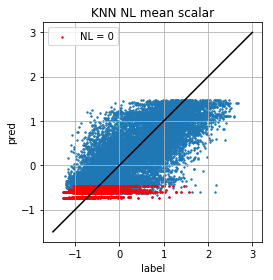

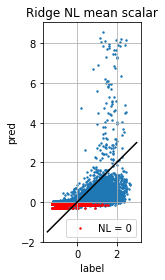

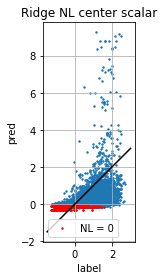

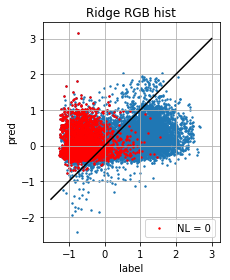

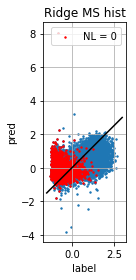

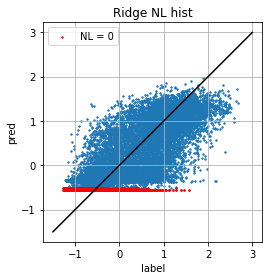

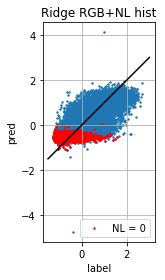

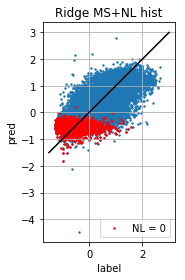

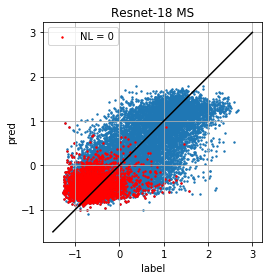

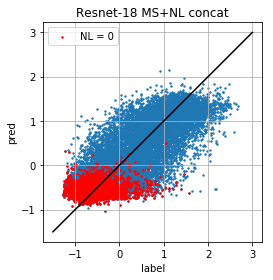

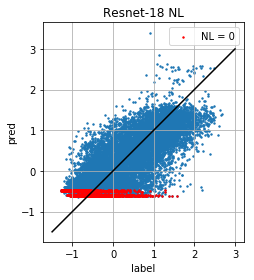

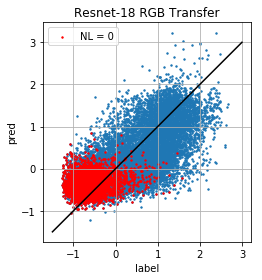

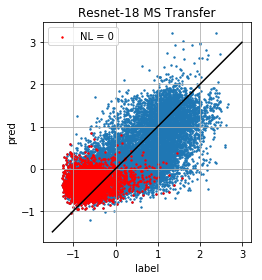

In [36]:
def plot_preds_nl0(model_name, labels, preds, nl0_indices):
    '''
    Args
    - model_name: str
    - labels: np.array, shape [num_examples]
    - preds: np.array, shape [num_examples]
    - nl0_indices: np.array, integer indices into labels/preds
    '''
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.scatter(x=labels, y=preds, s=2)
    ax.scatter(x=labels[nl0_indices], y=preds[nl0_indices], c='red', s=2, label='NL = 0')
    ax.set(xlabel='label', ylabel='pred', title=model_name)
    ax.grid(True)
    ax.set_aspect('equal')
    xy_line = np.array([-1.5, 3])
    ax.plot(xy_line, xy_line, color='black')
    ax.legend()
    fig.tight_layout()
    plt.show()

for model_name in MODEL_NAME_TO_DIR:
    plot_preds_nl0(model_name, labels, preds[model_name], nl0_indices)

In [37]:
nl0_df = evaluate_df(preds_df.loc[nl0_indices, :], cols=MODEL_NAMES)
nl0_df.sort_values('r2', ascending=False, inplace=True)
display(nl0_df.style.format('{:.3f}'))

,r2,R2,mse,rank
Ridge NL hist,0.133,-0.057,0.125,-0.349
Resnet-18 NL,0.108,-0.137,0.134,-0.362
Resnet-18 MS,0.044,-0.227,0.145,0.177
Resnet-18 MS Transfer,0.024,-0.676,0.198,0.130
Resnet-18 RGB Transfer,0.024,-0.676,0.198,0.130
Resnet-18 MS+NL concat,0.021,-0.064,0.126,0.109
Ridge NL center scalar,0.015,-1.852,0.337,-0.345
Ridge NL mean scalar,0.014,-1.895,0.342,-0.345
KNN NL mean scalar,0.011,0.007,0.117,0.062
Ridge MS hist,0.006,-2.943,0.465,-0.059


## Predictions vs. NL mean

In [38]:
def plot_preds_v_nl(model_name, preds, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - nl_means: np.array
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=preds, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Predicted Wealthpooled')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

def plot_residuals_v_nl(model_name, preds, labels, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - labels: np.array
    - nl_means: np.array
    '''
    residuals = labels - preds
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=residuals, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Residual (label - pred)')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

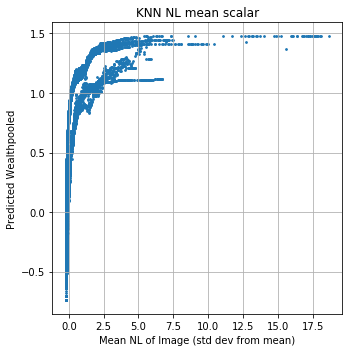

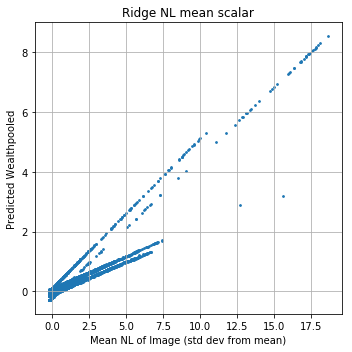

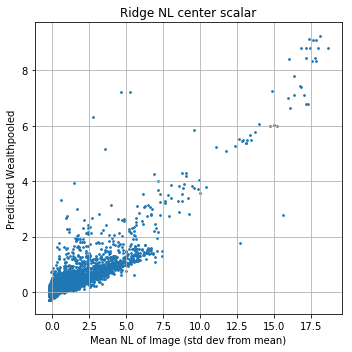

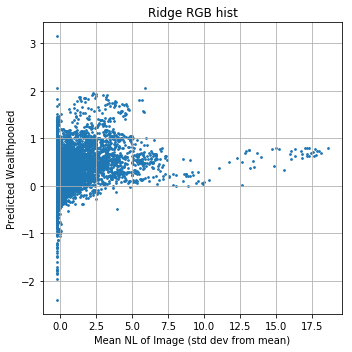

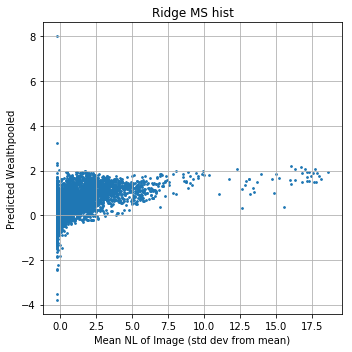

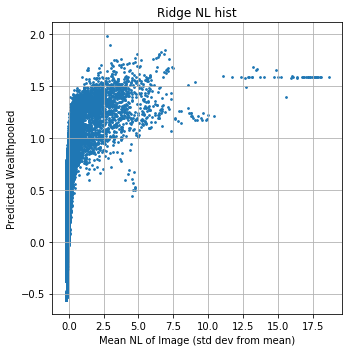

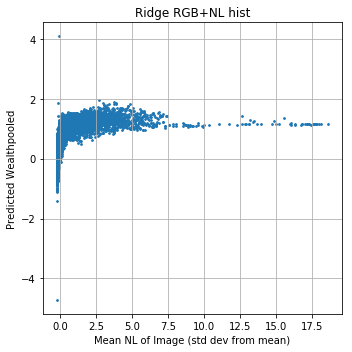

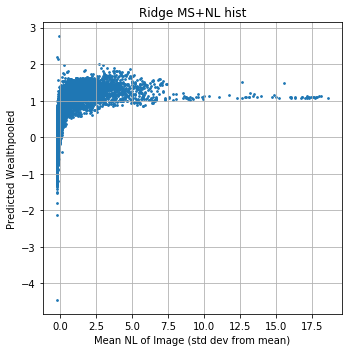

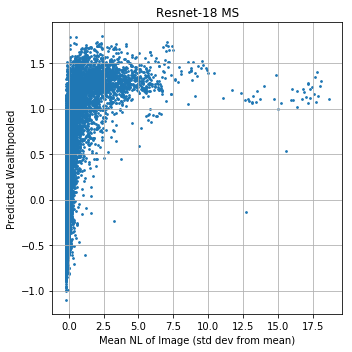

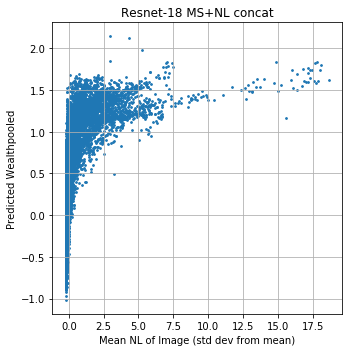

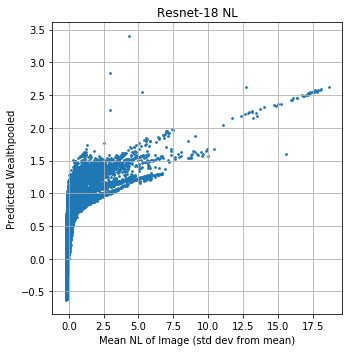

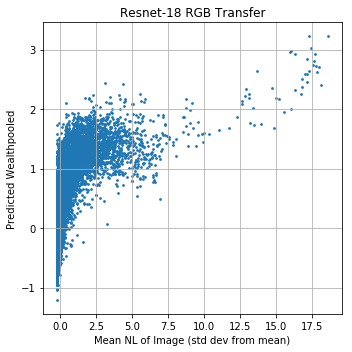

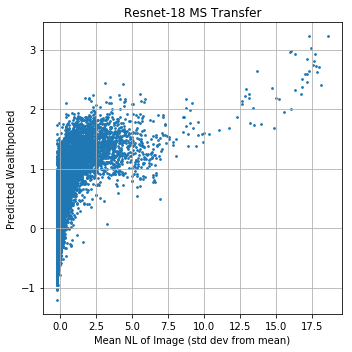

In [39]:
for model_name in MODEL_NAME_TO_DIR:
    plot_preds_v_nl(model_name, preds[model_name], nls_mean)

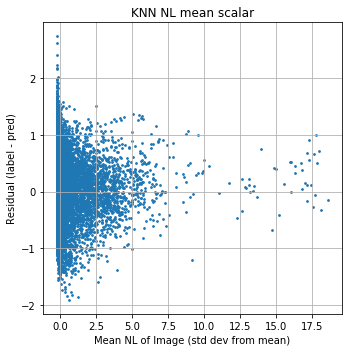

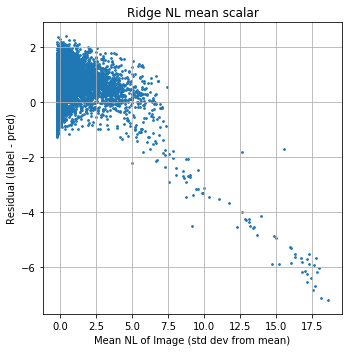

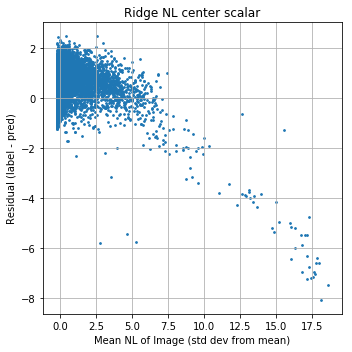

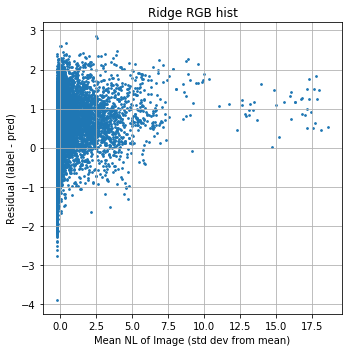

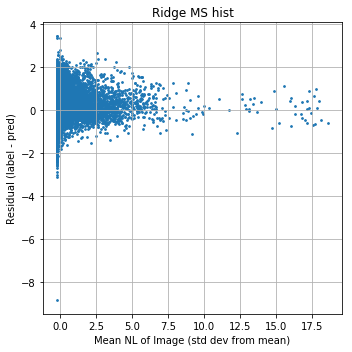

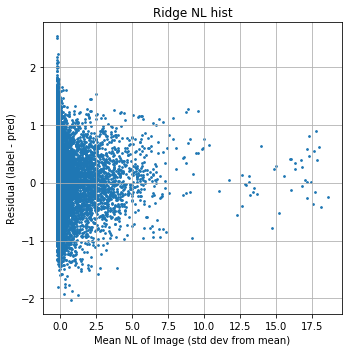

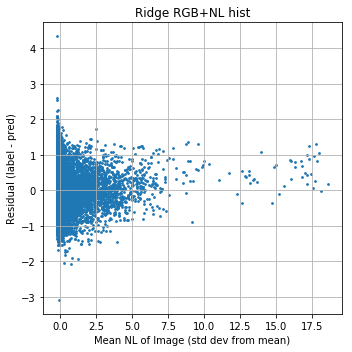

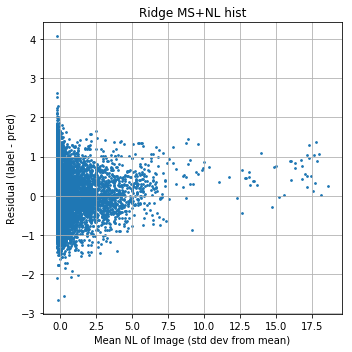

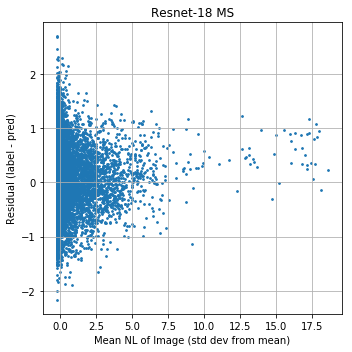

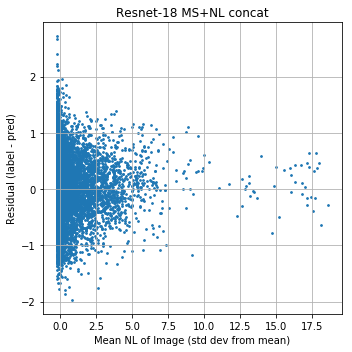

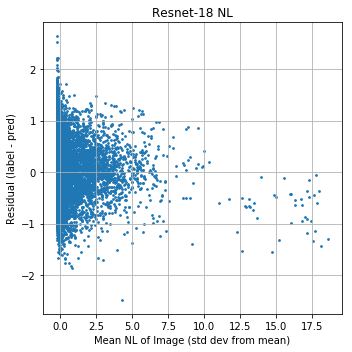

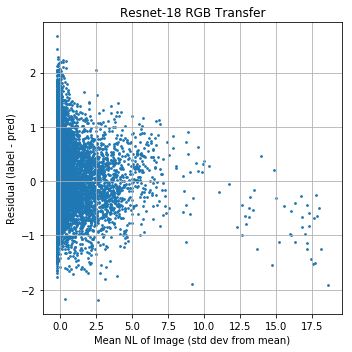

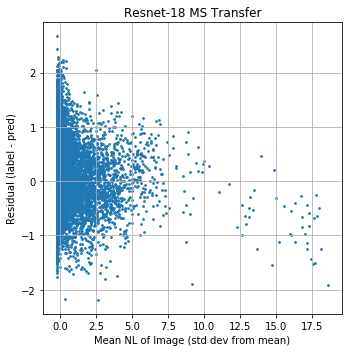

In [40]:
for model_name in MODEL_NAME_TO_DIR:
    plot_residuals_v_nl(model_name, preds[model_name], labels, nls_mean)